## Key Findings

1. **Scale**: Dataset covers substantial Claude usage across NC and US
2. **Collaboration**: Different collaboration patterns between regions  
3. **Tasks**: Hundreds of ONET task categories with multi-label usage
4. **Scope**: One-week snapshot (Aug 4-11, 2025)

# Exploratory Data Analysis: Anthropic Economic Index (AEI)

**Dataset**: Claude AI usage data (2025-08-04 to 2025-08-11)  
**Focus**: Comparing North Carolina vs US usage patterns

This notebook provides a lightweight, reproducible EDA of the raw AEI dataset.

## Setup & Data Loading

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'

# Ensure figures directory exists
os.makedirs('../figures', exist_ok=True)

In [31]:
# Load raw data
df = pd.read_csv('../data/raw/aei_raw_claude_ai_2025-08-04_to_2025-08-11.csv')
print(f"Dataset loaded: {df.shape[0]:,} rows x {df.shape[1]} columns")

Dataset loaded: 100,062 rows x 10 columns


## Basic Data Exploration

In [32]:
# Basic data overview
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Shape: (100062, 10)
Columns: ['geo_id', 'geography', 'date_start', 'date_end', 'platform_and_product', 'facet', 'level', 'variable', 'cluster_name', 'value']


In [33]:
# First few rows
df.head()

,geo_id,geography,date_start,date_end,platform_and_product,facet,level,variable,cluster_name,value
0,AD,country,2025-08-04,2025-08-11,Claude AI (Free and Pro),collaboration,0,collaboration_count,not_classified,25.0
1,AD,country,2025-08-04,2025-08-11,Claude AI (Free and Pro),collaboration,0,collaboration_pct,not_classified,62.5
2,AD,country,2025-08-04,2025-08-11,Claude AI (Free and Pro),collaboration,0,collaboration_count,task iteration,15.0
3,AD,country,2025-08-04,2025-08-11,Claude AI (Free and Pro),collaboration,0,collaboration_pct,task iteration,37.5
4,AD,country,2025-08-04,2025-08-11,Claude AI (Free and Pro),country,0,usage_count,NaN,40.0


In [34]:
# Key variables
print("Facets:", df['facet'].unique())
print("Variables:", df['variable'].unique())

Facets: ['collaboration' 'country' 'onet_task' 'request'
 'onet_task::collaboration' 'request::collaboration' 'state_us']
Variables: ['collaboration_count' 'collaboration_pct' 'usage_count' 'usage_pct'
 'onet_task_count' 'onet_task_pct' 'request_count' 'request_pct'
 'onet_task_collaboration_count' 'onet_task_collaboration_pct'
 'request_collaboration_count' 'request_collaboration_pct']


## Filter NC and US Data

In [35]:
# Filter NC and US data
df_nc = df[(df['geography'] == 'state_us') & (df['geo_id'] == 'NC')].copy()
df_us = df[(df['geography'] == 'country') & (df['geo_id'] == 'US')].copy()

# Exclude not_classified and none
exclude_clusters = ['not_classified', 'none']
df_nc = df_nc[~df_nc['cluster_name'].isin(exclude_clusters)]
df_us = df_us[~df_us['cluster_name'].isin(exclude_clusters)]

print(f"NC data: {df_nc.shape[0]:,} rows")
print(f"US data: {df_us.shape[0]:,} rows")

NC data: 532 rows
US data: 3,952 rows


## Collaboration Analysis

In [36]:
# Collaboration patterns
collab_nc = df_nc[(df_nc['facet'] == 'collaboration') & (df_nc['variable'] == 'collaboration_pct')]
collab_us = df_us[(df_us['facet'] == 'collaboration') & (df_us['variable'] == 'collaboration_pct')]

print("Collaboration patterns:")
print("NC:", list(collab_nc['cluster_name'].unique()))
print("US:", list(collab_us['cluster_name'].unique()))

Collaboration patterns:
NC: ['directive', 'feedback loop', 'learning', 'task iteration', 'validation']
US: ['directive', 'feedback loop', 'learning', 'task iteration', 'validation']


In [37]:
# Compare NC vs US collaboration
collab_comparison = pd.merge(
    collab_nc[['cluster_name', 'value']].rename(columns={'value': 'NC'}),
    collab_us[['cluster_name', 'value']].rename(columns={'value': 'US'}),
    on='cluster_name'
)

print("Collaboration comparison:")
print(collab_comparison.round(3))

Collaboration comparison:
     cluster_name      NC      US
0       directive  36.351  36.961
1   feedback loop   8.861   8.263
2        learning  22.616  21.272
3  task iteration  25.111  21.176
4      validation   4.759   4.482


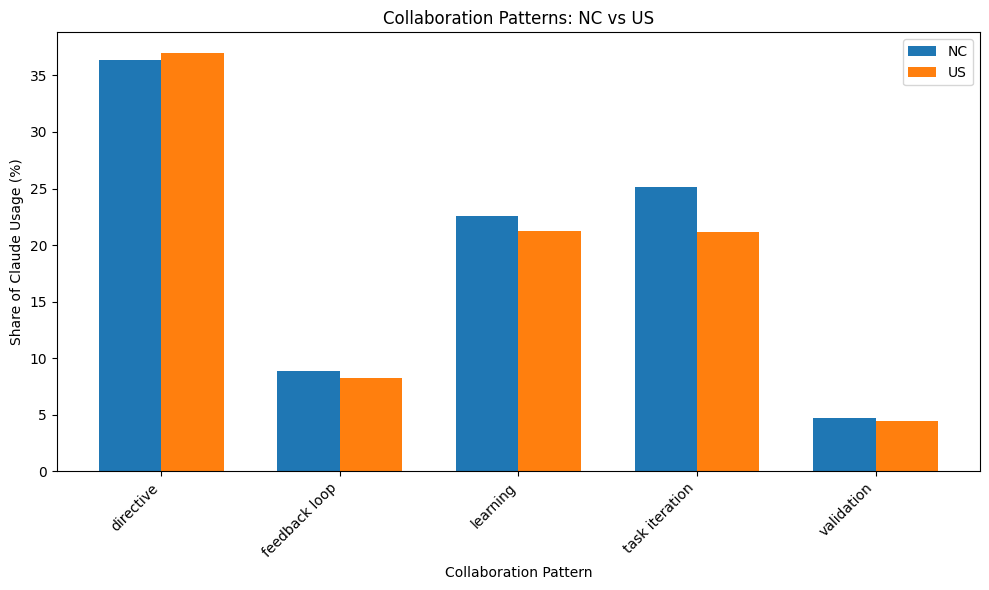

In [38]:
# Plot collaboration comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(collab_comparison))
width = 0.35

ax.bar(x - width/2, collab_comparison['NC'], width, label='NC', color='#1f77b4')
ax.bar(x + width/2, collab_comparison['US'], width, label='US', color='#ff7f0e')

ax.set_xlabel('Collaboration Pattern')
ax.set_ylabel('Share of Claude Usage (%)')
ax.set_title('Collaboration Patterns: NC vs US')
ax.set_xticks(x)
ax.set_xticklabels(collab_comparison['cluster_name'], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.savefig('../figures/eda_collab_nc_us.png', dpi=150, bbox_inches='tight')
plt.show()

## ONET Task Analysis

In [39]:
# ONET task overview
onet_nc = df_nc[df_nc['facet'] == 'onet_task']['cluster_name'].nunique()
onet_us = df_us[df_us['facet'] == 'onet_task']['cluster_name'].nunique()

print(f"ONET tasks in NC: {onet_nc}")
print(f"ONET tasks in US: {onet_us}")

ONET tasks in NC: 67
ONET tasks in US: 1254


In [40]:
# Top 10 NC tasks by percentage
onet_nc_pct = df_nc[
    (df_nc['facet'] == 'onet_task') & 
    (df_nc['variable'] == 'onet_task_pct')
][['cluster_name', 'value']].sort_values('value', ascending=False).head(10)

print("Top 10 ONET tasks in NC:")
for i, (_, row) in enumerate(onet_nc_pct.iterrows(), 1):
    print(f"{i:2d}. {row['cluster_name']}: {row['value']:.2f}%")

Top 10 ONET tasks in NC:
 1. write new programs or modify existing programs to meet customer requirements, using current programming languages and technologies.: 2.84%
 2. diagnose, troubleshoot, and resolve hardware, software, or other network and system problems, and replace defective components when necessary.: 2.28%
 3. modify existing software to correct errors, allow it to adapt to new hardware, or to improve its performance.: 1.99%
 4. edit or rewrite existing copy as necessary, and submit copy for approval by supervisor.: 1.76%
 5. perform routine system administrative functions such as troubleshooting, back-ups, and upgrades.: 1.59%
 6. prepare, rewrite and edit copy to improve readability, or supervise others who do this work.: 1.53%
 7. modify existing software to correct errors, to adapt it to new hardware, or to upgrade interfaces and improve performance.: 1.49%
 8. correct errors by making appropriate changes and rechecking the program to ensure that the desired results a

In [41]:
# Check if tasks are multi-label
total_nc = df_nc[(df_nc['facet'] == 'onet_task') & (df_nc['variable'] == 'onet_task_pct')]['value'].sum()
total_us = df_us[(df_us['facet'] == 'onet_task') & (df_us['variable'] == 'onet_task_pct')]['value'].sum()

print(f"Sum of onet_task_pct - NC: {total_nc:.2f}, US: {total_us:.2f}")
print(f"Tasks are {'multi-label' if total_nc > 1.0 else 'single-label'} (sum > 1.0)")

Sum of onet_task_pct - NC: 44.03, US: 82.83
Tasks are multi-label (sum > 1.0)
